In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS

np.random.seed(40)

C:\Users\marty\AppData\Local\Temp\ipykernel_27972\30193682.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
data = pd.read_csv("../data/our_data.csv")
prep_data = pd.read_csv("../data/our_data_preprocessed_MinMaxScaler.csv")

<h1>Selecting the number of components for PCA<h1>

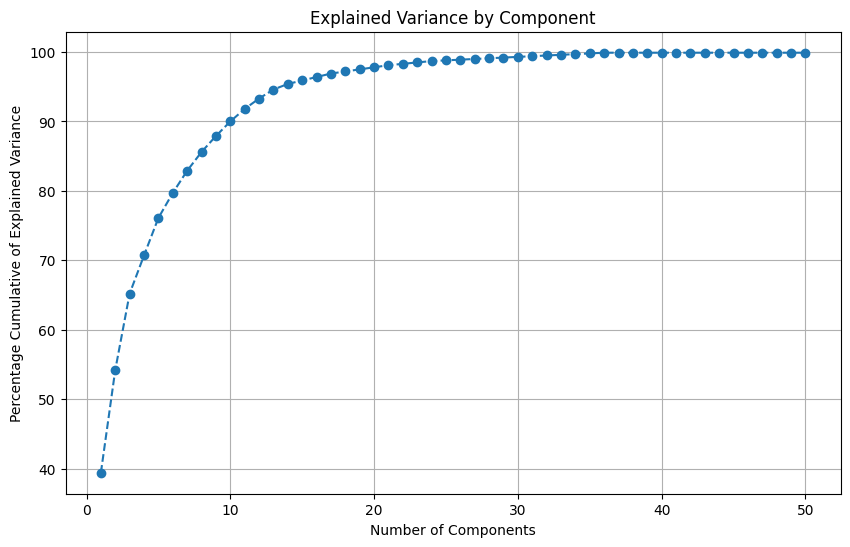

In [25]:
pca = PCA()
pca.fit(prep_data)
per_var = np.round(pca.explained_variance_ratio_*100, decimals = 1)

plt.figure(figsize = (10,6))
plt.plot(range(1, len(per_var)+1), per_var.cumsum(), marker = "o", linestyle = "--")
plt.grid()
plt.ylabel("Percentage Cumulative of Explained Variance")
plt.xlabel("Number of Components")
plt.title("Explained Variance by Component")
plt.show()

We would like to preserve at least 80% of our data so the minimum number of components is 7.

In [26]:
max_clusters = 10  
max_dimensions = prep_data.shape[1]//2 
results = []

for n_dims in range(8, max_dimensions + 1):
    pca = PCA(n_components=n_dims)
    pca_data = pca.fit_transform(prep_data)
    
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(pca_data)
        silhouette_avg = silhouette_score(pca_data, cluster_labels)
        calinski_harabasz = calinski_harabasz_score(pca_data, cluster_labels)
        davies_bouldin = davies_bouldin_score(pca_data, cluster_labels)
        results.append((n_dims, n_clusters, silhouette_avg, calinski_harabasz, davies_bouldin))


results_df = pd.DataFrame(results, columns=['n_dims', 'n_clusters', 'silhouette_score', 'calinski_harabasz_score', 'davies_bouldin_score'])

In [27]:
best_silhouette = results_df.loc[results_df['silhouette_score'].idxmax()]
best_calinski_harabasz = results_df.loc[results_df['calinski_harabasz_score'].idxmax()]
best_davies_bouldin = results_df.loc[results_df['davies_bouldin_score'].idxmin()] 

In [28]:
print(best_silhouette, best_calinski_harabasz, best_davies_bouldin)

n_dims                       8.000000
n_clusters                   4.000000
silhouette_score             0.338667
calinski_harabasz_score    312.338479
davies_bouldin_score         1.099568
Name: 2, dtype: float64 n_dims                       8.000000
n_clusters                   4.000000
silhouette_score             0.338667
calinski_harabasz_score    312.338479
davies_bouldin_score         1.099568
Name: 2, dtype: float64 n_dims                       9.000000
n_clusters                   4.000000
silhouette_score             0.333971
calinski_harabasz_score    300.101087
davies_bouldin_score         1.098817
Name: 11, dtype: float64


In [29]:
def count_wcss_scores(X, k_max):
    #  WCSS = within-cluster sum of squares
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1 # score returns -WCSS
        scores.append(wcss)
    return scores

def count_silhouette_scores(X, k_max):
    scores = []
    for k in range(2, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        labels = kmeans.labels_
        score = silhouette_score(X, labels)
        scores.append(score)
    return scores

def count_calinski_harabasz_scores(X, k_max):
    scores = []
    for k in range(2, k_max + 1):  # Calinski-Harabasz score nie działa dla k=1
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        labels = kmeans.labels_
        score = calinski_harabasz_score(X, labels)
        scores.append(score)
    return scores
def count_davies_bouldin_scores(X, k_max):
    scores = []
    for k in range(2, k_max + 1):  # Davies-Bouldin score nie działa dla k=1
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        labels = kmeans.labels_
        score = davies_bouldin_score(X, labels)
        scores.append(score)
    return scores

In [4]:
pca = PCA(n_components=8)
pca_data = pca.fit_transform(prep_data)

max_clusters = 15

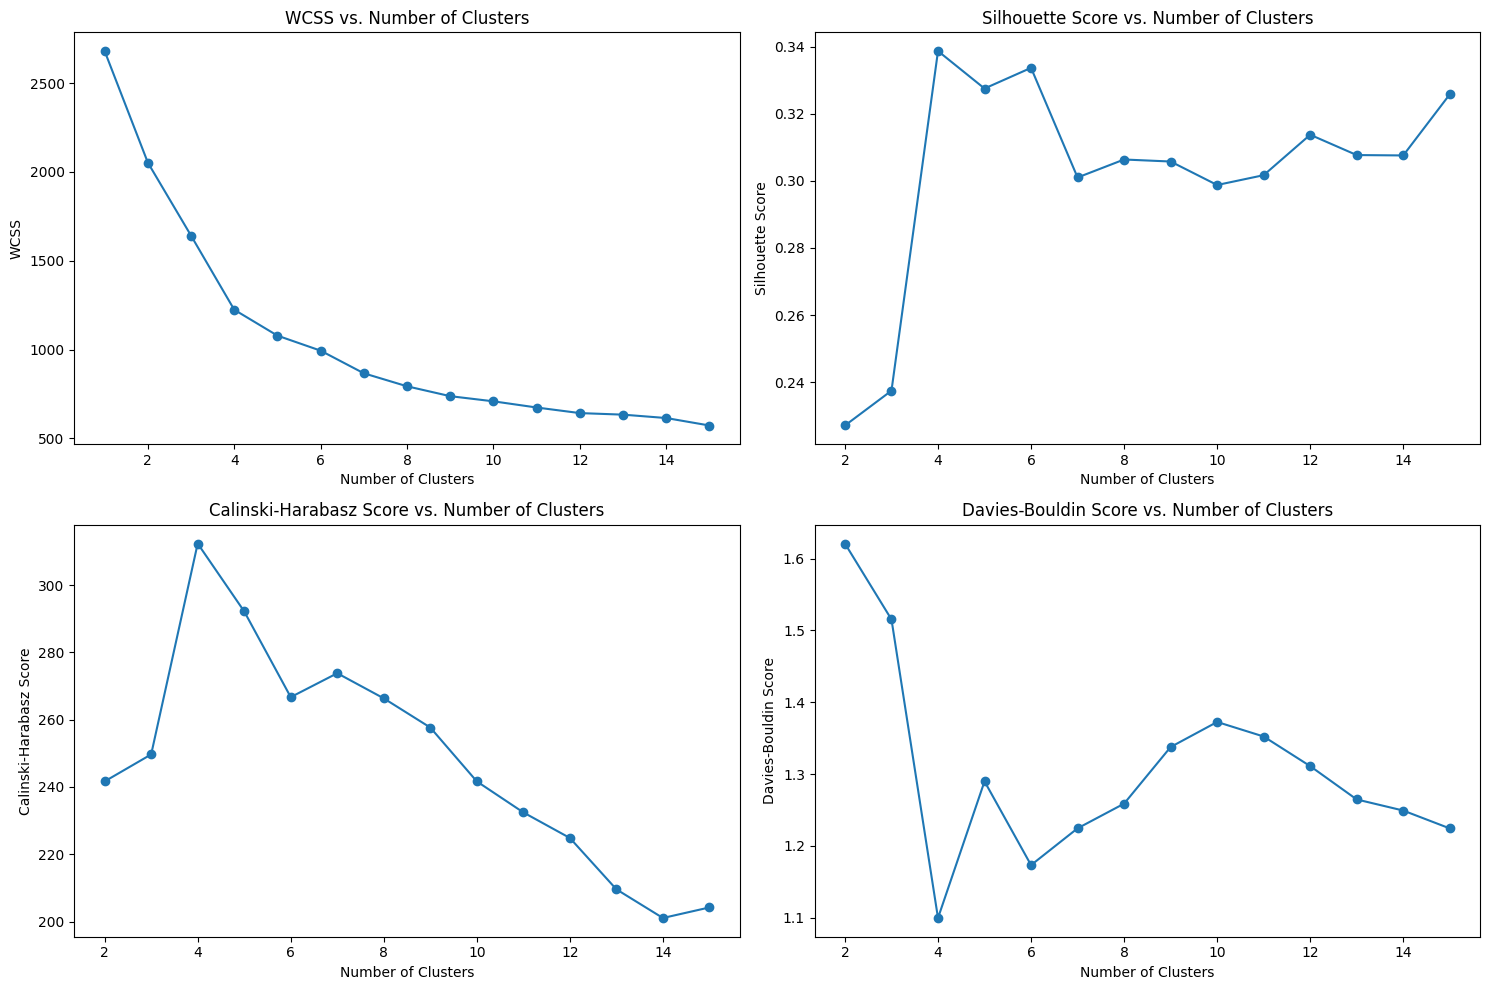

In [31]:
wcss_scores = count_wcss_scores(pca_data, max_clusters)
silhouette_scores = count_silhouette_scores(pca_data, max_clusters)
calinski_harabasz_scores = count_calinski_harabasz_scores(pca_data, max_clusters)
davies_bouldin_scores = count_davies_bouldin_scores(pca_data, max_clusters)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# WCSS Plot
axes[0, 0].plot(range(1, max_clusters + 1), wcss_scores, marker='o')
axes[0, 0].set_xlabel('Number of Clusters')
axes[0, 0].set_ylabel('WCSS')
axes[0, 0].set_title('WCSS vs. Number of Clusters')

# Silhouette Score Plot
axes[0, 1].plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
axes[0, 1].set_xlabel('Number of Clusters')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Silhouette Score vs. Number of Clusters')

# Calinski-Harabasz Score Plot
axes[1, 0].plot(range(2, max_clusters + 1), calinski_harabasz_scores, marker='o')
axes[1, 0].set_xlabel('Number of Clusters')
axes[1, 0].set_ylabel('Calinski-Harabasz Score')
axes[1, 0].set_title('Calinski-Harabasz Score vs. Number of Clusters')

# Davies-Bouldin Score Plot
axes[1, 1].plot(range(2, max_clusters + 1), davies_bouldin_scores, marker='o')
axes[1, 1].set_xlabel('Number of Clusters')
axes[1, 1].set_ylabel('Davies-Bouldin Score')
axes[1, 1].set_title('Davies-Bouldin Score vs. Number of Clusters')

plt.tight_layout()
plt.show()

The best number of clusters is 4. 

In [5]:
kmeans_k4 = KMeans(n_clusters=4, random_state=40)
data['Cluster_k4'] = kmeans_k4.fit_predict(prep_data)

In [33]:
def show_scores(data, cluster_col):
    print(cluster_col)
    print("Silhouette Score: ", silhouette_score(data, data[cluster_col]))
    print("Calinski-Harabasz Score: ", calinski_harabasz_score(data, data[cluster_col]))
    print("Davies-Bouldin Score: ", davies_bouldin_score(data, data[cluster_col]))

In [6]:
prep_data['Cluster_k4'] = data['Cluster_k4']

In [35]:
show_scores(prep_data, 'Cluster_k4')

Cluster_k4
Silhouette Score:  0.3362499888715211
Calinski-Harabasz Score:  372.5242116666582
Davies-Bouldin Score:  1.2051595975573441


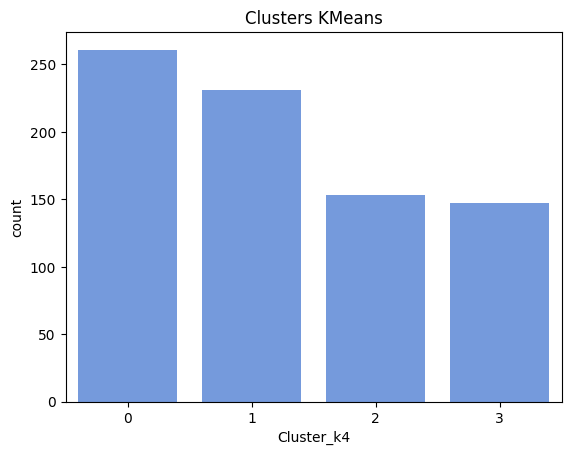

In [7]:
prep_data['Cluster_k4'].value_counts()

import matplotlib.pyplot as plt
import seaborn as sns

#clusters barplot
sns.countplot(data=prep_data, x='Cluster_k4', color='cornflowerblue')
plt.title('Clusters KMeans')
plt.show()

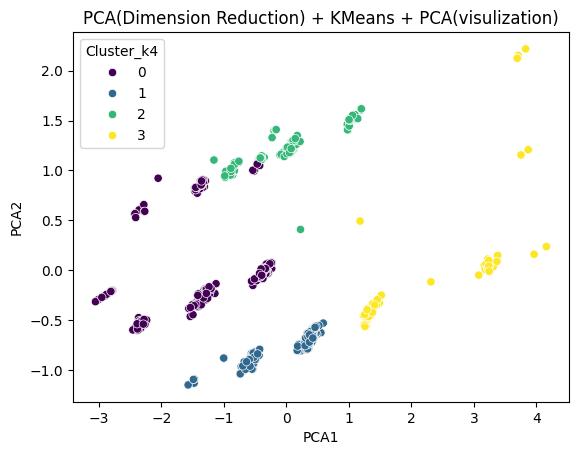

In [37]:

pca = PCA(n_components=2)
data_pca = pca.fit_transform(prep_data.drop('Cluster_k4', axis=1))

df_pca = pd.DataFrame(data=data_pca, columns=['PCA1', 'PCA2'])

df_pca['Cluster_k4'] = prep_data['Cluster_k4']

sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Cluster_k4', palette='viridis')
plt.title('PCA(Dimension Reduction) + KMeans + PCA(visulization)')
plt.show()

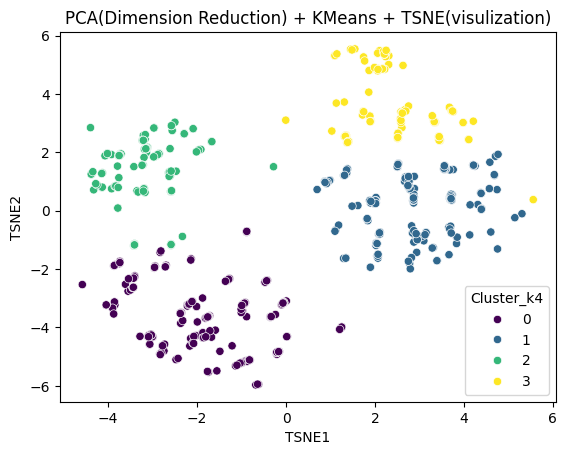

In [39]:


tsne = TSNE(n_components=2, random_state=0, perplexity=300, n_iter=300)
data_tsne = tsne.fit_transform(prep_data.drop('Cluster_k4', axis=1))

df_tsne = pd.DataFrame(data=data_tsne, columns=['TSNE1', 'TSNE2'])

df_tsne['Cluster_k4'] = prep_data['Cluster_k4']

sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Cluster_k4', palette='viridis')
plt.title('PCA(Dimension Reduction) + KMeans + TSNE(visulization)')
plt.show()

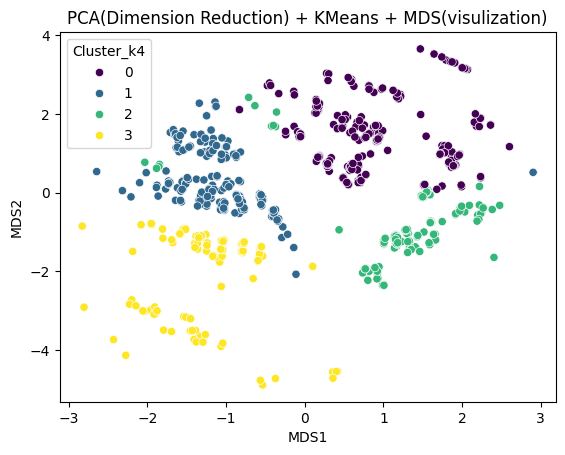

In [42]:
mds = MDS(n_components=2, random_state=0)
data_mds = mds.fit_transform(prep_data.drop('Cluster_k4', axis=1))

df_mds = pd.DataFrame(data=data_mds, columns=['MDS1', 'MDS2'])

df_mds['Cluster_k4'] = prep_data['Cluster_k4']

sns.scatterplot(data=df_mds, x='MDS1', y='MDS2', hue='Cluster_k4', palette='viridis')
plt.title('PCA(Dimension Reduction) + KMeans + MDS(visulization)')
plt.show()

C:\Users\marty\AppData\Local\Temp\ipykernel_27972\1389224241.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
C:\Users\marty\AppData\Local\Temp\ipykernel_27972\1389224241.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
C:\Users\marty\AppData\Local\Temp\ipykernel_27972\1389224241.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
C:\Users\marty\AppData\Local\Temp\ipykernel_27972\1389224241.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xtic

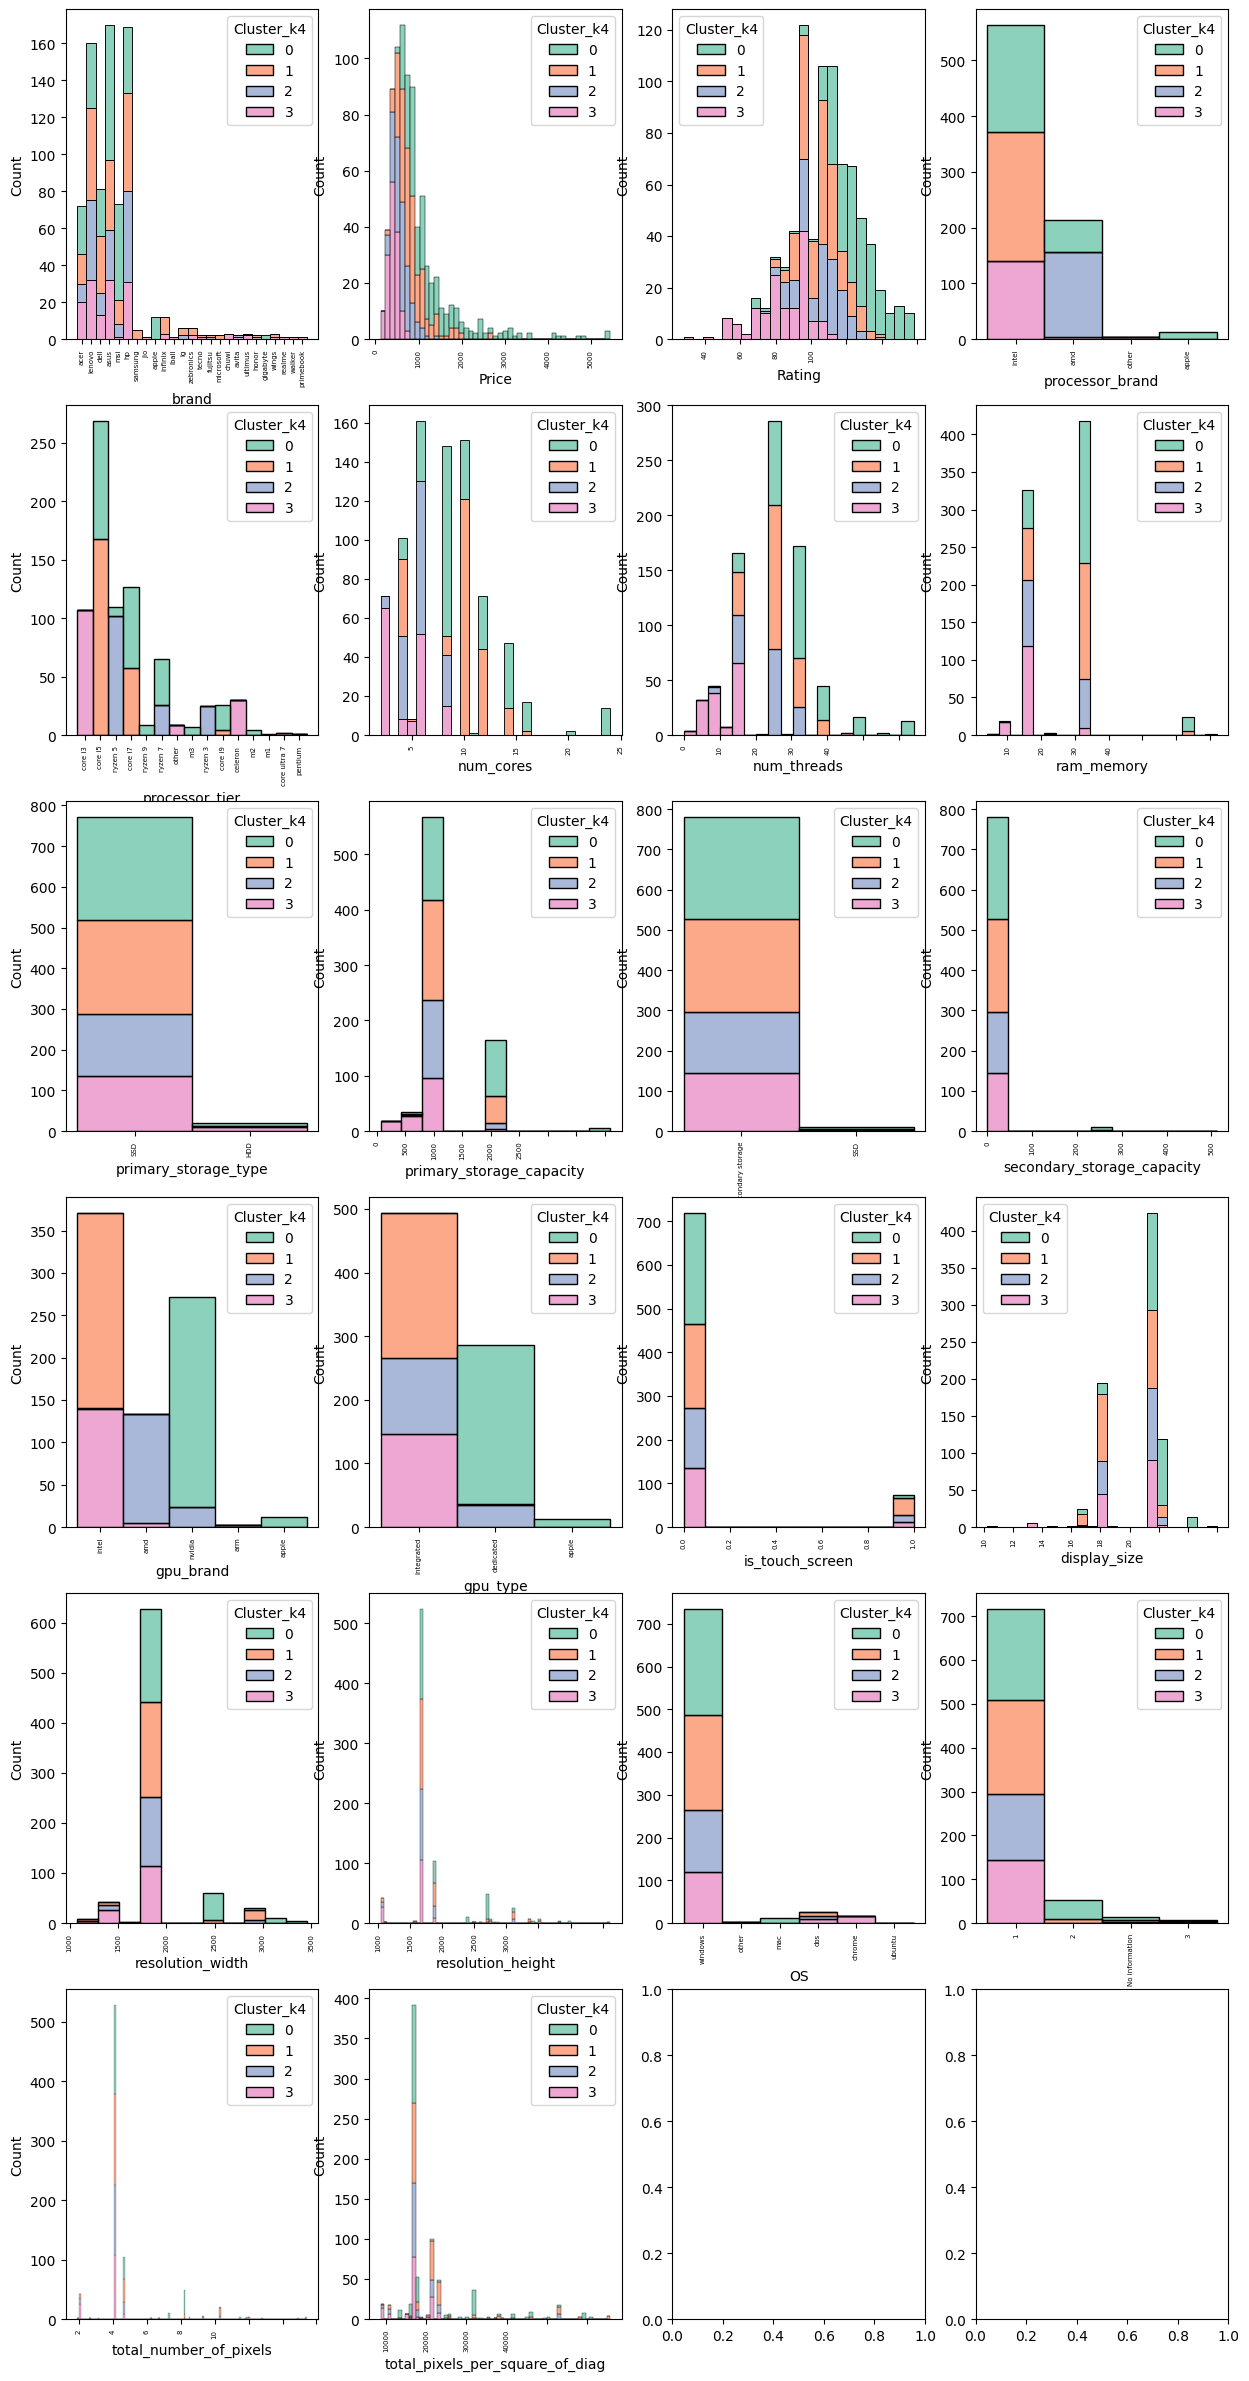

In [9]:
fig, axes = plt.subplots(6, 4, figsize=(15, 6 * 5))

axes = axes.flatten()

i=0
data = data.drop(['index', 'Model'], axis = 1)
for i, column in enumerate(data.columns):
    if column != 'Cluster_k4' :
        sns.histplot(data=data, x=column, hue="Cluster_k4", multiple="stack", ax=axes[i], palette='Set2')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
        axes[i].tick_params(axis='x', labelsize=5)
        axes[i].set_xlabel(column)
        i+=1

C:\Users\marty\AppData\Local\Temp\ipykernel_27972\1995668502.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_k4', y=column, data=data, ax = axes[i], palette="Set2")
C:\Users\marty\AppData\Local\Temp\ipykernel_27972\1995668502.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_k4', y=column, data=data, ax = axes[i], palette="Set2")
C:\Users\marty\AppData\Local\Temp\ipykernel_27972\1995668502.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_k4', y=column, data=data, ax = axes[i], palette="Set2")
C:\User

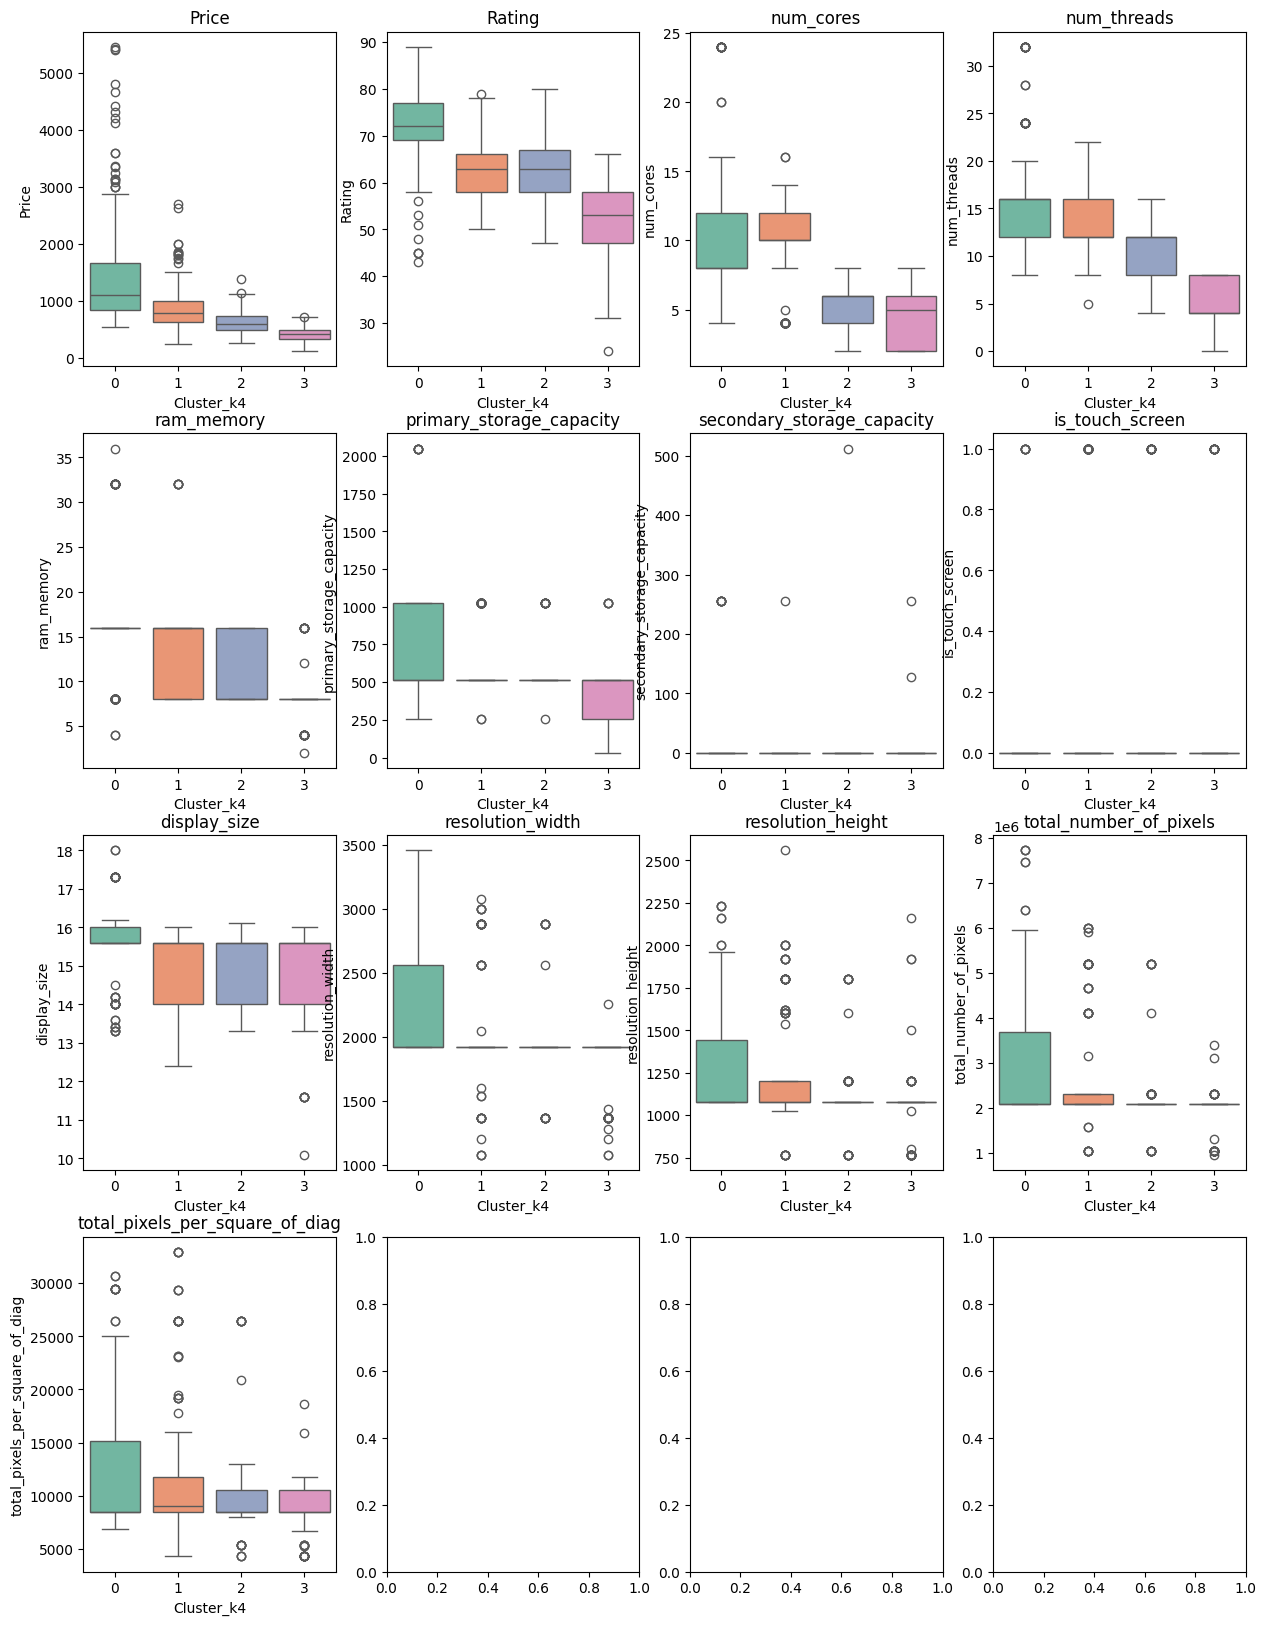

In [12]:
fig, axes = plt.subplots(4, 4, figsize=(15, 4 * 5))

axes = axes.flatten()
i=0
for column in data.columns:
    if column != 'Cluster_k4' and (type(data[column][0]) == np.float64 or type(data[column][0]) == np.int64):
        sns.boxplot(x='Cluster_k4', y=column, data=data, ax = axes[i], palette="Set2")
        axes[i].set_title(column)
        i+=1

Cluster 0: Laptops from top brands like apple, lenovo, asus. Laptops with high price and rating. Laptops with nvidia gpu and the highest display resolution. 

Cluster 1: A bit cheaper and lower rated laptops. Mostly with intel processor. Most of the laptops with touch screen are included in this cluster.

Cluster 2: Many of hp laptops. Processor and gpu is amd. Price is lower than 1000 USD

Cluster 3: The cheapest and the lowest rated laptops. Processors are mostly intel. 